# Building a pipeline

In [60]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline, FeatureUnion

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('SFE_data.csv', index_col=0)

In [3]:
# Set categorical variables
to_cat = ['MinTemp_uDP', 'MinTemp_u20', 'MaxTemp_uDP','MaxTemp_u20', 
          'MeanTemp_uDP', 'MeanTemp_u20', 'MinTemp_uDPSum_1', 'MinTemp_uDPSum_3', 
          'MinTemp_uDPSum_7','MaxTemp_uDPSum_1', 'MaxTemp_uDPSum_3', 'MaxTemp_uDPSum_7',
       'MeanTemp_uDPSum_1', 'MeanTemp_uDPSum_3', 'MeanTemp_uDPSum_7',
       'MinTemp_u20Sum_1', 'MinTemp_u20Sum_3', 'MinTemp_u20Sum_7',
       'MaxTemp_u20Sum_1', 'MaxTemp_u20Sum_3', 'MaxTemp_u20Sum_7',
       'MeanTemp_u20Sum_1', 'MeanTemp_u20Sum_3', 'MeanTemp_u20Sum_7','month', 'year', 'YearWeek']

for col in to_cat:
    df[col] = df[col].astype(object)

In [5]:
df.shape

(933, 79)

In [6]:
#drop cols that could lead to overfitting, and ones with only one category
to_drop = ['Date', 'year', 'FieldID', 'JDay', 'MaxTemp_uDP', 'MeanTemp_uDP', 
           'MaxTemp_uDPSum_1',
       'MaxTemp_uDPSum_3', 'MaxTemp_uDPSum_7', 'MeanTemp_uDPSum_1',
       'MeanTemp_uDPSum_3', 'MeanTemp_uDPSum_7','MinTemp_u20', 'MinTemp_u20Sum_1',
       'MinTemp_u20Sum_3', 'MinTemp_u20Sum_7',]
df.drop(labels=to_drop, axis=1, inplace=True)

In [7]:
df.head()

,SsMean,Crop,MinTemp_y,MaxTemp_y,MeanTemp_y,MeanRH_y,Precip,Wind2,Wind10,Wind10Dir,...,MaxTemp_u20Sum_7,MeanTemp_u20Sum_1,MeanTemp_u20Sum_3,MeanTemp_u20Sum_7,SsMean_1,SsMean_3,SsMean_7,month,YearWeek,logSsMean
4,14.95,unknown,8.6,23.0,16.6,63.8,0.0,7.0,7.7,282.8,...,3.0,1.0,3.0,7.0,14.95,14.95,14.95,6,24,2.769459
5,9.71,unknown,9.0,22.7,15.7,72.6,0.1,9.0,10.5,166.6,...,2.0,1.0,3.0,7.0,14.95,14.95,14.95,6,25,2.371178
6,57.75,unknown,12.4,24.7,18.5,59.5,0.0,9.0,10.0,188.6,...,1.0,1.0,3.0,7.0,9.71,9.71,9.71,6,25,4.073291
7,6.67,unknown,6.9,27.1,18.5,62.6,0.0,10.4,12.2,160.4,...,1.0,1.0,3.0,7.0,57.75,27.47,27.47,6,25,2.037317
8,107.32,unknown,9.6,30.2,21.1,59.5,0.0,12.4,15.3,148.2,...,1.0,1.0,3.0,7.0,6.67,24.71,24.71,6,25,4.685090


#### Build Pipeline

In [9]:
# separate out target variable
X = df.drop(labels=['SsMean','logSsMean'], axis=1)
# using logSsMean was also tried, led to poorer model performance
y = df.SsMean

In [10]:
# create pipeline

# select continuous and categorical varables
cat_feats = X.dtypes[X.dtypes == 'object'].index.tolist()
num_feats = X.dtypes[~X.dtypes.index.isin(cat_feats)].index.tolist()

# create functions to isolate datatypes
def numFeat(data):
    return data[num_feats]

def catFeat(data):
    return data[cat_feats]

# create fit_transform for feature functions
keep_num = FunctionTransformer(numFeat)
keep_cat = FunctionTransformer(catFeat)

# label encoder won't work in pipeline, will use one hot encoding
encoder = OneHotEncoder()

# will need to densify after encoding
class ToDenseTransformer():
    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
    def fit(self, X, y=None, **fit_params):
        return self
        
# select kbest
kbest = SelectKBest(k=30)

# select PCA components
pca = PCA(n_components=4)

# scale
scaler = StandardScaler()

In [12]:
cat_preprocessing = Pipeline([
    ('cats', keep_cat),
    ('encode', encoder),
    ('densify', ToDenseTransformer())
])

num_preprocessing = Pipeline([
    ('nums', keep_num),
])

values_union = FeatureUnion([
    ('cat_cols', cat_preprocessing),
    ('num_cols', num_preprocessing),
])

feature_union = FeatureUnion([
    ('pca', pca),
    ('select_best', kbest)
])

#### SVM

In [26]:
# fit model
base_model = SVR()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    #('features', feature_union), # better performance without feature selection
    ('model', base_model)
])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7ffae03a7280>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7ffae03ac130>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7ffae03a7310>))]))])),
                ('scale', StandardScaler()), ('model', SVR())])

Training acc: -0.07770356927107702
Testing acc: -0.0747795184929787
Train Mean squared error:  10420196.197371716
Test Mean squared error:  24454152.65874216
Train MAE:  1043.617920333086
Test MAE:  1503.901815429798
Train RMSE:  3228.032868074877
Test RMSE:  4945.114018780776
Train corr:  (0.2522113481017955, 2.7408086320333963e-12)
Test corr:  (0.16830378451467223, 0.02130489008191786)


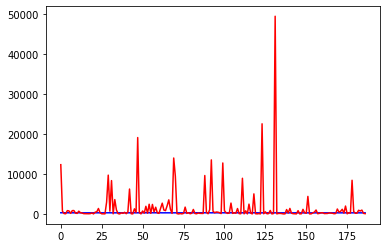

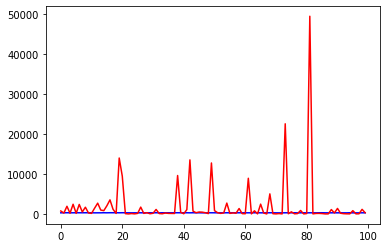

In [27]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

train_rmse = mean_squared_error(y_train, train_pred, squared=False)
print('Train RMSE: ', train_rmse)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Test RMSE: ', test_rmse)

from scipy.stats import pearsonr as pearson
train_pearson = pearson(y_train, train_pred)
print('Train corr: ', train_pearson)
test_pearson = pearson(y_test, y_pred)
print('Test corr: ', test_pearson)

# plot test
plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

# plot closeup of test
plt.plot(y_pred[50:150], c='b')
plt.plot(y_test.values[50:150], c='r')
plt.show()

#### Linear Regression

In [28]:
# fit model
base_model = LinearRegression()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    #('features', feature_union), # better performance without feature selection
    ('model', base_model)
])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7ffae03a7280>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7ffae03ac130>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7ffae03a7310>))]))])),
                ('scale', StandardScaler()), ('model', LinearRegression(

Training acc: 0.37808262677003623
Testing acc: 0.31355054276574557
Train Mean squared error:  6013250.055387189
Test Mean squared error:  15618589.237032266
Train MAE:  1240.2967539785416
Test MAE:  1597.4943942558332
Train RMSE:  2452.1929074579734
Test RMSE:  3952.036087516442
Train corr:  (0.6152788388094308, 6.582584026191402e-79)
Test corr:  (0.6057806212083133, 4.104591286593098e-20)


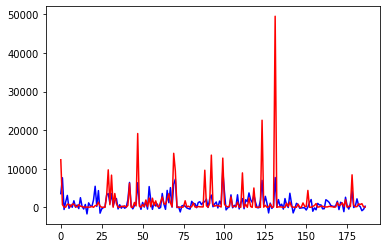

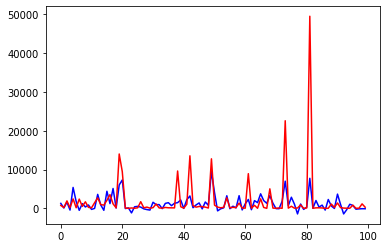

In [29]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

train_rmse = mean_squared_error(y_train, train_pred, squared=False)
print('Train RMSE: ', train_rmse)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Test RMSE: ', test_rmse)

from scipy.stats import pearsonr as pearson
train_pearson = pearson(y_train, train_pred)
print('Train corr: ', train_pearson)
test_pearson = pearson(y_test, y_pred)
print('Test corr: ', test_pearson)

# plot test
plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

# plot closeup of test
plt.plot(y_pred[50:150], c='b')
plt.plot(y_test.values[50:150], c='r')
plt.show()

#### Ridge Regression

In [40]:
# fit model
# Lasso also tried, with similar performance
base_model = Ridge()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    #('features', feature_union), # better performance without feature selection
    ('model', base_model)
])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7ffae03a7280>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7ffae03ac130>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7ffae03a7310>))]))])),
                ('scale', StandardScaler()), ('model', Ridge())])

Training acc: 0.3803636248017722
Testing acc: 0.3216073008672877
Train Mean squared error:  5991195.338585439
Test Mean squared error:  15435276.111726409
Train MAE:  1197.6283025071953
Test MAE:  1541.0320032859868
Train RMSE:  2447.691838975127
Test RMSE:  3928.775395937824
Train corr:  (0.6167470255313076, 2.2203750819590803e-79)
Test corr:  (0.6215202653789439, 2.2775094816338973e-21)


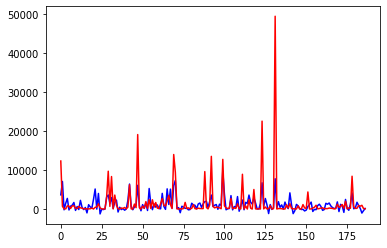

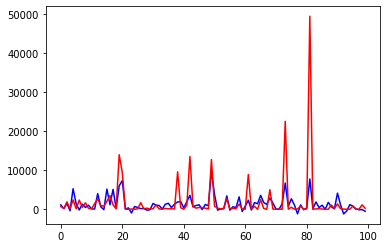

In [41]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

train_rmse = mean_squared_error(y_train, train_pred, squared=False)
print('Train RMSE: ', train_rmse)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Test RMSE: ', test_rmse)

from scipy.stats import pearsonr as pearson
train_pearson = pearson(y_train, train_pred)
print('Train corr: ', train_pearson)
test_pearson = pearson(y_test, y_pred)
print('Test corr: ', test_pearson)

# plot test
plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

# plot closeup of test
plt.plot(y_pred[50:150], c='b')
plt.plot(y_test.values[50:150], c='r')
plt.show()

#### XGBoost Regression

In [96]:
# fit model
base_model = xgb.XGBRegressor()

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    #('features', feature_union), # better performance without feature selection
    ('model', base_model)
])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7ffae03a7280>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7ffae03ac130>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7ffae03a7310>))]))]))...
                              colsample_bytree=1, gamma=0, gpu_id=-1,


Training acc: 0.9999769303867057
Testing acc: 0.46998227783316526
Train Mean squared error:  223.0575304550984
Test Mean squared error:  12059342.466704475
Train MAE:  10.397672775839021
Test MAE:  1310.7770707188185
Train RMSE:  14.935110660959241
Test RMSE:  3472.6563991711696
Train corr:  (0.9999887542788912, 0.0)
Test corr:  (0.7696265646720302, 6.82261162488359e-38)


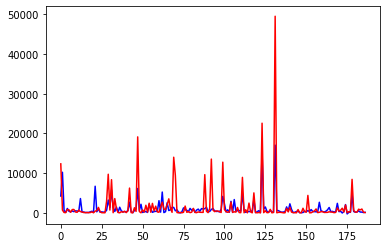

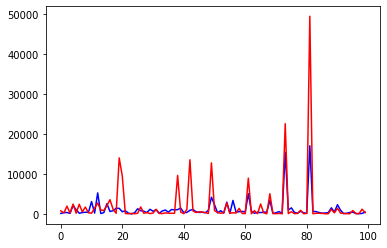

In [97]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

train_rmse = mean_squared_error(y_train, train_pred, squared=False)
print('Train RMSE: ', train_rmse)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Test RMSE: ', test_rmse)

from scipy.stats import pearsonr as pearson
train_pearson = pearson(y_train, train_pred)
print('Train corr: ', train_pearson)
test_pearson = pearson(y_test, y_pred)
print('Test corr: ', test_pearson)

# plot test
plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

# plot closeup of test
plt.plot(y_pred[50:150], c='b')
plt.plot(y_test.values[50:150], c='r')
plt.show()

#### *Move forward with XGBoost

#### Build Classification system

In [75]:
# although accuracy is low, correlation is okay and model seems to be predicting spikes to some degree
# create a classification system to see performance
# will need to determin custom classification thresholds for model

In [49]:
# get an idea for target distribution
df.SsMean.describe()

count      933.000000
mean      1241.957622
std       3512.085184
min          0.000000
25%         86.000000
50%        268.880000
75%        827.670000
max      49537.972050
Name: SsMean, dtype: float64

In [50]:
print(df[df['SsMean'] > 5000].SsMean.count()) # ~top 5% of counts
print(df[df['SsMean'] > 2500].SsMean.count()) # ~top 10% of counts

52
95


In [90]:
# classifier function 2500
def classify_2500(data):
    if data < 2500:
        return 0
    else:
        return 1

# classifier function 5000
def classify_5000(data):
    if data < 5000:
        return 0
    else:
        return 1

# function to filter roc_curve thresholds
def thresholds(false, true, th):
    rc = list(zip(false, true, th))
    to_try = []
    for i in rc:
        fp = i[0]
        tp = i[1]
        t = i[2]
        if (fp <= 0.4) & (tp >= 0.8):
            to_try.append(i)
    return to_try
    
def thresholds_2500():
    print("2500 classification threshold")
    # apply classifier and print AUC scores
    train_auc = roc_auc_score(y_train.apply(classify_2500),train_pred)
    print('Train auc:', train_auc)
    test_auc = roc_auc_score(y_test.apply(classify_2500),y_pred)
    print('Test auc:', test_auc)

    # calculate roc_auc curve 
    fpr, tpr, thresh = roc_curve(y_test.apply(classify_2500),y_pred)

    # plot
    plt.plot(fpr, tpr)
    plt.show()
    
    holds = thresholds(fpr, tpr, thresh)
    print(holds)
    
def thresholds_5000():
    print("2500 classification threshold")
    # apply classifier and print AUC scores
    train_auc = roc_auc_score(y_train.apply(classify_5000),train_pred)
    print('Train auc:', train_auc)
    test_auc = roc_auc_score(y_test.apply(classify_5000),y_pred)
    print('Test auc:', test_auc)

    # calculate roc_auc curve 
    fpr, tpr, thresh = roc_curve(y_test.apply(classify_5000),y_pred)

    # plot
    plt.plot(fpr, tpr)
    plt.show()
    
    holds = thresholds(fpr, tpr, thresh)
    print(holds)
    
# function to show result from custom classification
def custom_results(model_threshold, true_cl):
    # define model threshold classes
    def model_cl(data):
        if data < model_threshold:
            return 0
        else:
            return 1
    # build dataframe with true and predicted labels
    # train
    train_result = pd.DataFrame()
    train_result['train_pred'] = train_pred
    train_result['train_pred_label'] = train_result.train_pred.apply(model_cl)
    train_result['y_train'] = y_train.values
    train_result['train_true_label'] = train_result.y_train.apply(true_cl)
    #test
    test_result = pd.DataFrame()
    test_result['y_pred'] = y_pred
    test_result['pred_label'] = test_result.y_pred.apply(model_cl)
    test_result['y'] = y_test.values
    test_result['true_label'] = test_result.y.apply(true_cl)
    # performance evaluations
    train_precision = precision_score(train_result.train_true_label, train_result.train_pred_label)
    test_precision = precision_score(test_result.true_label, test_result.pred_label)
    print('Train precision:', train_precision)
    print('Test precision:', test_precision)

    train_recall = recall_score(train_result.train_true_label, train_result.train_pred_label)
    test_recall = recall_score(test_result.true_label, test_result.pred_label)
    print('Train recall:', train_recall)
    print('Test recall:', test_recall)

    train_f1 = f1_score(train_result.train_true_label, train_result.train_pred_label)
    test_f1 = f1_score(test_result.true_label, test_result.pred_label)
    print('F1 score train:', train_f1)
    print('F1 score test:', test_f1)

    cr = classification_report(test_result.true_label, test_result.pred_label)
    print(cr)

    cm = confusion_matrix(test_result.true_label, test_result.pred_label)
    plot_confusion_matrix(cm, classes=[0,1])
    
# convenience function to plot confustion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Baseline XGBoost Classification Permormance

2500 classification threshold
Train auc: 1.0
Test auc: 0.8838209982788297


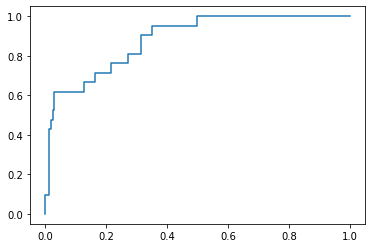

[(0.2710843373493976, 0.8095238095238095, 629.43353), (0.3132530120481928, 0.8095238095238095, 575.782), (0.3132530120481928, 0.9047619047619048, 565.7472), (0.3493975903614458, 0.9047619047619048, 503.88397), (0.3493975903614458, 0.9523809523809523, 503.5062)]


In [98]:
# 2500
thresholds_2500()

Train precision: 0.2901960784313726
Test precision: 0.2564102564102564
Train recall: 1.0
Test recall: 0.9523809523809523
F1 score train: 0.44984802431610943
F1 score test: 0.40404040404040403
              precision    recall  f1-score   support

           0       0.99      0.65      0.79       166
           1       0.26      0.95      0.40        21

    accuracy                           0.68       187
   macro avg       0.62      0.80      0.59       187
weighted avg       0.91      0.68      0.74       187



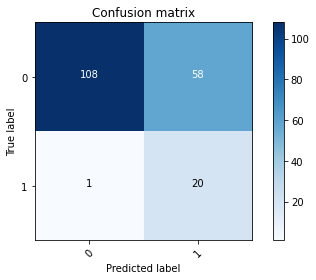

In [100]:
# 2500 performace
custom_results(500, classify_2500)

2500 classification threshold
Train auc: 1.0
Test auc: 0.9282945736434108


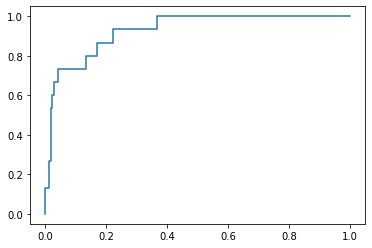

[(0.13372093023255813, 0.8, 1359.2766), (0.1686046511627907, 0.8, 1061.8708), (0.1686046511627907, 0.8666666666666667, 1036.7358), (0.22093023255813954, 0.8666666666666667, 871.64795), (0.22093023255813954, 0.9333333333333333, 856.4169), (0.36627906976744184, 0.9333333333333333, 503.88397), (0.36627906976744184, 1.0, 503.5062)]


In [101]:
# 5000 
thresholds_5000()

Train precision: 0.1450980392156863
Test precision: 0.19230769230769232
Train recall: 1.0
Test recall: 1.0
F1 score train: 0.2534246575342466
F1 score test: 0.32258064516129037
              precision    recall  f1-score   support

           0       1.00      0.63      0.78       172
           1       0.19      1.00      0.32        15

    accuracy                           0.66       187
   macro avg       0.60      0.82      0.55       187
weighted avg       0.94      0.66      0.74       187



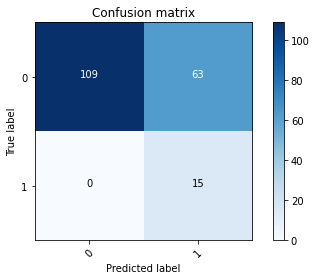

In [104]:
custom_results(500, classify_5000)

#### Tuned XGBoost Model

In [105]:
# fit model
base_model = xgb.XGBRegressor(eta=0.4, max_depth=5)

pipeline = Pipeline(steps=[
    ('values', values_union),
    ('scale', scaler),
    #('features', feature_union), # better performance without feature selection
    ('model', base_model)
])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('values',
                 FeatureUnion(transformer_list=[('cat_cols',
                                                 Pipeline(steps=[('cats',
                                                                  FunctionTransformer(func=<function catFeat at 0x7ffae03a7280>)),
                                                                 ('encode',
                                                                  OneHotEncoder()),
                                                                 ('densify',
                                                                  <__main__.ToDenseTransformer object at 0x7ffae03ac130>)])),
                                                ('num_cols',
                                                 Pipeline(steps=[('nums',
                                                                  FunctionTransformer(func=<function numFeat at 0x7ffae03a7310>))]))]))...
                              colsample_bytree=1, eta=0.4, gamma=0, gp

Training acc: 0.9999479823738021
Testing acc: 0.46879899811830783
Train Mean squared error:  502.9526542912304
Test Mean squared error:  12086265.293467764
Train MAE:  15.753115438589328
Test MAE:  1302.6711633151388
Train RMSE:  22.42660594675954
Test RMSE:  3476.530640375224
Train corr:  (0.999974354836766, 0.0)
Test corr:  (0.7340715567022117, 6.375371373004795e-33)


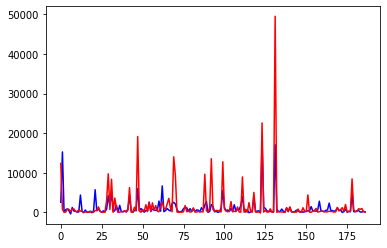

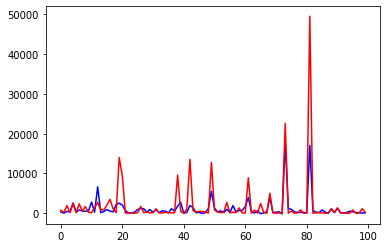

In [106]:
# evaluate

xg = pipeline

y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

train_rmse = mean_squared_error(y_train, train_pred, squared=False)
print('Train RMSE: ', train_rmse)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print('Test RMSE: ', test_rmse)

from scipy.stats import pearsonr as pearson
train_pearson = pearson(y_train, train_pred)
print('Train corr: ', train_pearson)
test_pearson = pearson(y_test, y_pred)
print('Test corr: ', test_pearson)

# plot test
plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

# plot closeup of test
plt.plot(y_pred[50:150], c='b')
plt.plot(y_test.values[50:150], c='r')
plt.show()

2500 classification threshold
Train auc: 1.0
Test auc: 0.9084911072862879


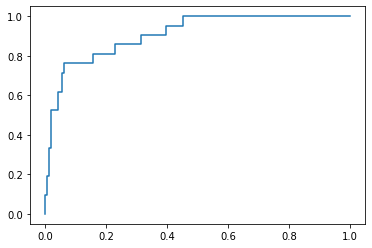

[(0.1566265060240964, 0.8095238095238095, 990.1304), (0.2289156626506024, 0.8095238095238095, 796.28296), (0.2289156626506024, 0.8571428571428571, 770.80664), (0.3132530120481928, 0.8571428571428571, 544.39703), (0.3132530120481928, 0.9047619047619048, 544.39374), (0.39759036144578314, 0.9047619047619048, 408.2735), (0.39759036144578314, 0.9523809523809523, 402.01355)]


In [107]:
thresholds_2500()

Train precision: 0.3070539419087137
Test precision: 0.2608695652173913
Train recall: 1.0
Test recall: 0.8571428571428571
F1 score train: 0.46984126984126984
F1 score test: 0.4
              precision    recall  f1-score   support

           0       0.97      0.69      0.81       166
           1       0.26      0.86      0.40        21

    accuracy                           0.71       187
   macro avg       0.62      0.77      0.60       187
weighted avg       0.89      0.71      0.76       187



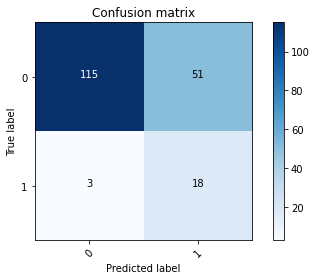

In [111]:
custom_results(550, classify_2500)

2500 classification threshold
Train auc: 1.0
Test auc: 0.9713178294573643


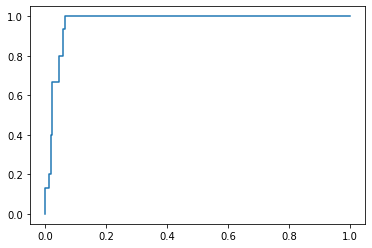

[(0.046511627906976744, 0.8, 2523.6428), (0.05813953488372093, 0.8, 2193.0386), (0.05813953488372093, 0.9333333333333333, 1947.4546), (0.06395348837209303, 0.9333333333333333, 1913.2313), (0.06395348837209303, 1.0, 1817.0765)]


In [112]:
thresholds_5000()

Train precision: 0.37
Test precision: 0.5769230769230769
Train recall: 1.0
Test recall: 1.0
F1 score train: 0.5401459854014599
F1 score test: 0.7317073170731707
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       172
           1       0.58      1.00      0.73        15

    accuracy                           0.94       187
   macro avg       0.79      0.97      0.85       187
weighted avg       0.97      0.94      0.95       187



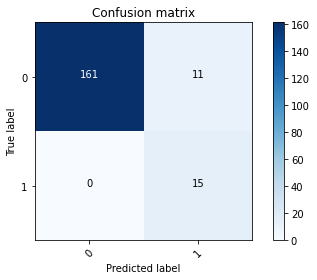

In [115]:
custom_results(1800, classify_5000)

In [116]:
import pickle

filename = 'XGBR14.sav'
pickle.dump(pipeline, open(filename, 'wb'))

In [117]:
load_model = pickle.load(open(filename, 'rb'))

In [118]:
y_pred = load_model.predict(X_test)
test_acc = xg.score(X_test, y_test)
print(test_acc)

0.46879899811830783
